In [1]:
from data_pipeline import data_creation, preprocessing, dataset_order
from models.mlp_model import MLP
from models.kan_model import KANWrapper
from models.train_test import train_mlp, train_kan
import torch
import pickle
from data_pipeline.real_data import load_small_dataset
from config.hyperparameters import (
    KAN_WIDTH, KAN_GRID,
    MLP_WIDTH,
    TIMESERIES_LENGTH, INPUT_LEN, PRED_LEN, 
    NOISE, SCALE
)

In [2]:
df = data_creation.create_time_series(TIMESERIES_LENGTH, ["trend", "seasonality"], noise=NOISE, scale=SCALE)
X, y = preprocessing.create_windows(df, input_len=INPUT_LEN, pred_len=PRED_LEN)
X_train, X_test, y_train, y_test = dataset_order.split_dataset(X, y)

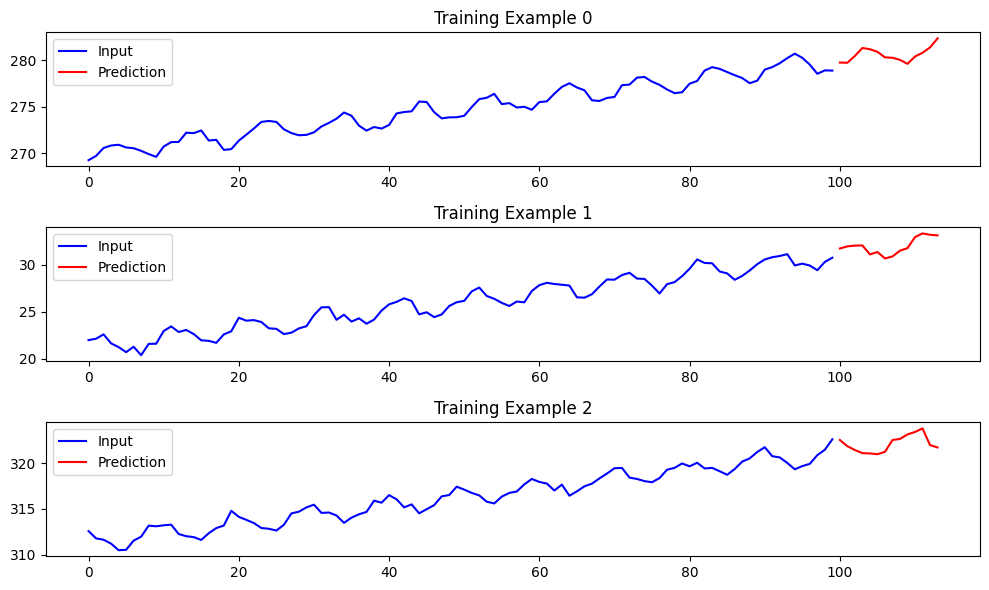

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i in range(3):
    x_vals = X_train[i]
    y_vals = y_train[i]

    if not hasattr(y_vals, '__len__'):
        y_vals = [y_vals]

    input_x = list(range(len(x_vals)))
    pred_x = list(range(len(x_vals), len(x_vals) + len(y_vals)))

    axs[i].plot(input_x, x_vals, color='blue', label='Input')

    axs[i].plot(pred_x, y_vals, color='red', label='Prediction')

    axs[i].set_title(f"Training Example {i}")
    axs[i].legend()

plt.tight_layout()
plt.show()

sunspots: shape = (309, 1)


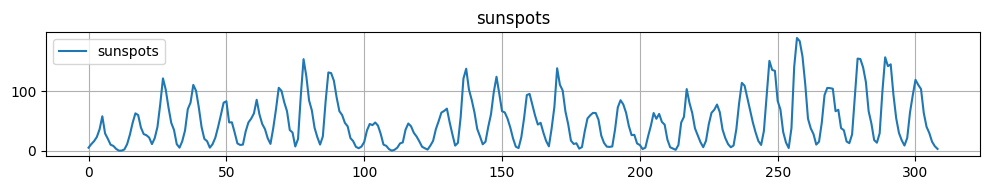

daily_temp: shape = (3650, 1)


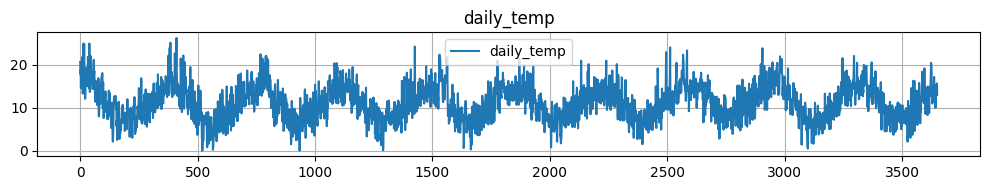

co2: shape = (2225, 1)


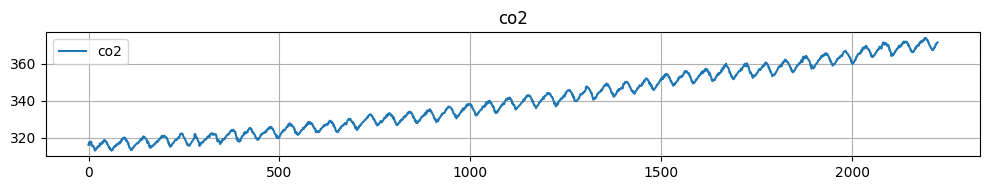

In [4]:
dataset_names = ["sunspots", "daily_temp", "co2"]
loaded_datasets = {}

for name in dataset_names:
    try:
        data = load_small_dataset(name)
        loaded_datasets[name] = data
        print(f"{name}: shape = {data.shape}")
        
        # Plot the time series
        plt.figure(figsize=(10, 2))
        plt.plot(data, label=name)
        plt.title(name)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"{name} failed to load: {e}")

In [6]:
mlp_model = MLP(MLP_WIDTH)
train_mlp(mlp_model, X_train, y_train, X_test, y_test, name="mlp")

with open("mlp_model.pkl", "wb") as f:
    pickle.dump(mlp_model, f)

[mlp] Epoch   0 | Train Loss: 87075.5703 | Test Loss: 80238.0703
[mlp] Epoch  10 | Train Loss: 18752.9102 | Test Loss: 12350.3604
[mlp] Epoch  20 | Train Loss: 512.9890 | Test Loss: 802.1696
[mlp] Epoch  30 | Train Loss: 1474.7135 | Test Loss: 1613.7316
[mlp] Epoch  40 | Train Loss: 349.2659 | Test Loss: 381.3137
[mlp] Epoch  50 | Train Loss: 243.5909 | Test Loss: 257.6489
[mlp] Epoch  60 | Train Loss: 92.6174 | Test Loss: 65.2968
[mlp] Epoch  70 | Train Loss: 23.2112 | Test Loss: 21.9460
[mlp] Epoch  80 | Train Loss: 16.7548 | Test Loss: 18.0563
[mlp] Epoch  90 | Train Loss: 12.4689 | Test Loss: 11.7987
[mlp] Epoch  99 | Train Loss: 9.5800 | Test Loss: 9.8125


In [ ]:
kan_model = KANWrapper(width=KAN_WIDTH, grid=KAN_GRID)
train_kan(kan_model, X_train, y_train, X_test, y_test)

print("Pruning...")
kan_model.model = kan_model.model.prune()

print("Plotting splines...")
kan_model(torch.tensor(X_test, dtype=torch.float32))
kan_model.model.plot()

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.86e-01 | test_loss: 7.90e-01 | reg: 7.03e+01 | : 100%|█| 50/50 [00:26<00:00,  1.92it

saving model version 0.1
Pruning...
saving model version 0.2


AttributeError: Can't pickle local object 'Symbolic_KANLayer.__init__.<locals>.<listcomp>.<listcomp>.<lambda>'

In [ ]:
from sympy import symbols
import torch

kan_model(torch.tensor(X_test[:1], dtype=torch.float32))

input_vars = symbols(f'x0:{X.shape[1]}')
formulas = kan_model.model.symbolic_formula(var=input_vars)
print(formulas[0][0])

0


/Users/bromum/.pyenv/versions/3.10.4/lib/python3.10/site-packages/kan/MultKAN.py:816: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/Users/bromum/.pyenv/versions/3.10.4/lib/python3.10/site-packages/kan/MultKAN.py:826: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  input_range = torch.std(preacts, dim=0) + 0.1
/Users/bromum/.pyenv/versions/3.10.4/lib/python3.10/site-packages/kan/MultKAN.py:827: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input n